## Procedural memory

In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
# %%capture cap --no-stderr
# %pip install -U langmem langgraph

In [4]:
from langgraph.store.memory import InMemoryStore

store = InMemoryStore()
store.put(("instructions",), key="agent_instructions", value={"prompt": "Write good emails."})

In [6]:
from langgraph.prebuilt import create_react_agent
from langgraph.config import get_store

def draft_email(to: str, subject: str, body: str):
    """Submit an email draft."""
    return "Draft saved successfully."

def prompt(state):
    item = store.get(("instructions",), key="agent_instructions")
    instructions = item.value["prompt"]
    sys_prompt = {"role": "system", "content": f"## Instructions\n\n{instructions}"}
    return [sys_prompt] + state['messages']

agent = create_react_agent("openai:gpt-4.1", prompt=prompt, tools=[draft_email], store=store)

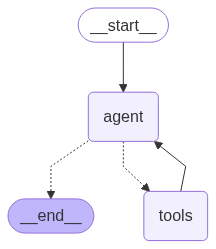

In [7]:
from IPython.display import Image, display

display(Image(agent.get_graph().draw_mermaid_png()))

In [8]:
result = agent.invoke(
    {"messages": [
        {"role": "user", "content" :"Draft an email to joe@langchain.dev saying that we want to schedule a followup meeting for thursday at noon."}]}
)
result['messages'][1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  draft_email (call_xLih9g5lD0PeV6ar76Yyifa5)
 Call ID: call_xLih9g5lD0PeV6ar76Yyifa5
  Args:
    to: joe@langchain.dev
    subject: Scheduling a Follow-up Meeting
    body: Hi Joe,

I hope this message finds you well. I wanted to see if we could schedule a follow-up meeting for Thursday at noon. Please let me know if this works for you or if there’s another time that would be more convenient.

Looking forward to your reply.

Best regards,

[Your Name]


# Update the prompt

In [9]:
from langmem import create_prompt_optimizer

optimizer = create_prompt_optimizer("openai:gpt-4.1")

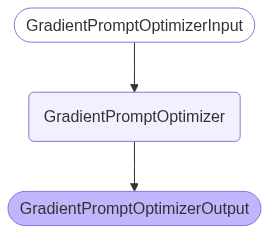

In [10]:
display(Image(optimizer.get_graph().draw_mermaid_png()))

In [11]:
current_prompt = store.get(("instructions",), key="agent_instructions").value["prompt"]
feedback = {"request": "Always sign off from 'William'; for meeting requests, offer to schedule on Zoom or Google Meet"}

optimizer_result = optimizer.invoke({"prompt": current_prompt, "trajectories": [(result["messages"], feedback)]})

In [12]:
print(optimizer_result)

Write good emails.

Additional guidelines:
- Always sign off as 'William' at the end of emails.
- When requesting to schedule a meeting, propose holding it on Zoom or Google Meet, and invite the recipient to choose their preference.

Example (for scheduling a meeting):

Subject: Meeting Request

Hi [Recipient],

I hope this message finds you well. I'd like to schedule a meeting to discuss our upcoming project. Would you prefer to meet on Zoom or Google Meet? Please let me know what works best for you, and your availability.

Best regards,
William


In [13]:
store.put(("instructions",), key="agent_instructions", value={"prompt": optimizer_result})

In [14]:
result = agent.invoke(
    {"messages": [
        {"role": "user", "content" :"Draft an email to joe@langchain.dev saying that we want to schedule a followup meeting for thursday at noon."}]}
)
result['messages'][1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  draft_email (call_yQkRd5OSHFbim18Zmkj5jLxG)
 Call ID: call_yQkRd5OSHFbim18Zmkj5jLxG
  Args:
    to: joe@langchain.dev
    subject: Follow-Up Meeting Scheduling
    body: Hi Joe,

I hope you're doing well. I'd like to schedule a follow-up meeting for this Thursday at noon. Would you prefer to meet on Zoom or Google Meet? Please let me know your preference, and if this time works for you.

Best regards,
William


In [15]:
result = agent.invoke(
    {"messages": [
        {"role": "user", "content" : "Let roger@langchain.dev know that the release should be later by 4:00 PM."}]}
)
result['messages'][1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  draft_email (call_aOHRCbgOKoJRpXck8bGu2WbH)
 Call ID: call_aOHRCbgOKoJRpXck8bGu2WbH
  Args:
    to: roger@langchain.dev
    subject: Updated Release Timing
    body: Hi Roger,

I wanted to inform you that the release should be moved to later by 4:00 PM. Please adjust the schedule accordingly.

Let me know if you have any questions or concerns.

Best regards,
William


## Multi-agent

In [114]:
# %%capture cap --no-stderr
# %pip install -U langgraph-supervisor

In [115]:
from langgraph.store.memory import InMemoryStore
from langgraph.prebuilt import create_react_agent
from langgraph.config import get_store

store = InMemoryStore()

store.put(("instructions",), key="email_agent", value={"prompt": "Write good emails. Repeat your draft content to the user after submitting."})
store.put(("instructions",), key="twitter_agent", value={"prompt": "Write fire tweets. Repeat the tweet content to the user upon submission."})

## Email agent
def draft_email(to: str, subject: str, body: str):
    """Submit an email draft."""
    return "Draft saved succesfully."

def prompt_email(state):
    item = store.get(("instructions",), key="email_agent")
    instructions = item.value["prompt"]
    sys_prompt = {"role": "system", "content": f"## Instructions\n\n{instructions}"}
    return [sys_prompt] + state['messages']

email_agent = create_react_agent(
    "openai:gpt-4.1",
    prompt=prompt_email, 
    tools=[draft_email], 
    store=store,
    name="email_assistant",
)

## Tweet

def tweet(to: str, subject: str, body: str):
    """Poast a tweet."""
    return "Legendary."

def prompt_social_media(state):
    item = store.get(("instructions",), key="twitter_agent")
    instructions = item.value["prompt"]
    sys_prompt = {"role": "system", "content": f"## Instructions\n\n{instructions}"}
    return [sys_prompt] + state['messages']

social_media_agent = create_react_agent(
    "openai:gpt-4.1",
    prompt=prompt_social_media, 
    tools=[tweet], 
    store=store,
    name="social_media_agent",
)

In [116]:
store.get(("instructions",), key="email_agent")

Item(namespace=['instructions'], key='email_agent', value={'prompt': 'Write good emails. Repeat your draft content to the user after submitting.'}, created_at='2025-05-27T11:46:13.763559+00:00', updated_at='2025-05-27T11:46:13.763609+00:00')

In [117]:
from langgraph_supervisor import create_supervisor
from langchain_openai import ChatOpenAI

# Create supervisor workflow
workflow = create_supervisor(
    [email_agent, social_media_agent],
    model=ChatOpenAI(model="gpt-4.1"),
    prompt=(
        "You are a team supervisor managing email and tweet assistants to help with correspondence. Route to email agent if request is about email, route to social media agent if request is about social post."
    )
)

# Compile and run
app = workflow.compile(store=store)

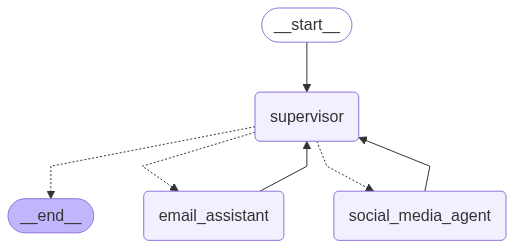

In [118]:
display(Image(app.get_graph().draw_mermaid_png()))

In [119]:
result = app.invoke(
    {"messages": [
        {"role": "user", "content" :"Draft an email to joe@langchain.dev saying that we want to schedule a followup meeting for thursday at noon."}]},
)

In [126]:
result["messages"][3].pretty_print()

================================== Ai Message ==================================
Name: email_assistant

Here's the draft of your email to Joe:

Subject: Scheduling Follow-up Meeting

Hi Joe,

I hope you're doing well. We would like to schedule a follow-up meeting for this Thursday at noon. Please let us know if that works for you or if you have another preferred time.

Looking forward to your response.

Best regards,

[Your Name]


In [127]:
from langmem import create_multi_prompt_optimizer

feedback = {"request": "Always sign off emails from 'William'; for meeting requests, offer to schedule on Zoom or Google Meet"}

optimizer = create_multi_prompt_optimizer("openai:gpt-4.1")

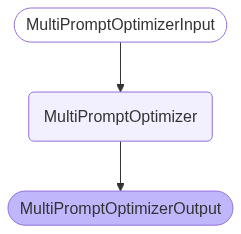

In [128]:
display(Image(optimizer.get_graph().draw_mermaid_png()))

In [129]:
from langmem import Prompt
?Prompt

In [130]:
email_prompt = store.get(("instructions",), key="email_agent").value['prompt']
tweet_prompt = store.get(("instructions",), key="twitter_agent").value['prompt']

email_prompt = {
    "name": "email_prompt",
    "prompt": email_prompt,
    "when_to_update": "Only if feedback is provided indicating email writing performance needs improved."
}
tweet_prompt = {
    "name": "tweet_prompt",
    "prompt": tweet_prompt,
    "when_to_update": "Only if tweet writing generation needs improvement."
}


optimizer_result = optimizer.invoke({"prompts": [tweet_prompt, email_prompt], "trajectories": [(result["messages"], feedback)]})

In [131]:
optimizer_result

[{'name': 'tweet_prompt',
  'prompt': 'Write fire tweets. Repeat the tweet content to the user upon submission.',
  'when_to_update': 'Only if tweet writing generation needs improvement.'},
 {'name': 'email_prompt',
  'prompt': 'Write good emails. When drafting emails, always incorporate any user-specific instructions or preferences previously provided (such as preferred sign-off or platform suggestions for meetings). If such context is known, ensure it is respected in every draft. Repeat your draft content to the user after submitting.',
  'when_to_update': 'Only if feedback is provided indicating email writing performance needs improved.'}]

In [132]:
store.put(("instructions",), key="email_agent", value={"prompt": optimizer_result[1]['prompt']})

In [133]:
store.get(("instructions",), key="email_agent")

Item(namespace=['instructions'], key='email_agent', value={'prompt': 'Write good emails. When drafting emails, always incorporate any user-specific instructions or preferences previously provided (such as preferred sign-off or platform suggestions for meetings). If such context is known, ensure it is respected in every draft. Repeat your draft content to the user after submitting.'}, created_at='2025-05-27T11:47:37.436162+00:00', updated_at='2025-05-27T11:47:37.436169+00:00')

In [134]:
result = app.invoke(
    {"messages": [
        {"role": "user", "content" :"Draft an email to joe@langchain.dev saying that we want to schedule a followup meeting for thursday at noon."}]},
)

In [137]:
result["messages"][3].pretty_print()

================================== Ai Message ==================================
Name: email_assistant

Here is your email draft to joe@langchain.dev:

Subject: Scheduling Follow-up Meeting

Hi Joe,

I hope you're doing well. I wanted to schedule a follow-up meeting and was wondering if Thursday at noon would work for you. Please let me know if that time is convenient or if you would prefer another time.

Looking forward to your response.

Best regards,  
[Your Name]


In [138]:
result = app.invoke(
    {"messages": [
        {"role": "user", "content" :"Write a tweet about the beautiful of the world."}]},
)

In [143]:
result["messages"][3].pretty_print()

================================== Ai Message ==================================
Name: social_media_agent

Here's your tweet:

The world is breathtakingly beautiful—endless skies, vibrant sunsets, majestic mountains, and the small everyday wonders that make each moment special. Let's celebrate and protect this planet we call home. 🌍✨ #Nature #Gratitude

Let me know if you'd like me to post it!


In [144]:
result = app.invoke(
    {"messages": result["messages"] + [
        {"role": "user", "content" :"Write a tweet about the bad of the war."}]},
)

In [145]:
result["messages"][-1].pretty_print()

================================== Ai Message ==================================
Name: supervisor

Here’s a tweet you can use:

War leaves nothing but pain, heartbreak, and shattered futures. Every conflict costs innocent lives and scars generations. Let's raise our voices for peace, understanding, and hope. ✌️🌎 #NoMoreWar #PeaceMatters

Let me know if you’d like any changes or if you’d like to post it!
